In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [1]:
# export
from fastai.basic_train import LearnerCallback

In [2]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [3]:
# export
from fastai.core import *

In [4]:
# export
from IPython.core import debugger as idb

In [5]:
# export
import sys 
sys.path.append("..")
sys.path.append("../detect_symbol")

from detect_symbol.exp import nb_databunch
from detect_symbol.exp import nb_resnet_ssd
from detect_symbol.exp import nb_init_model
from detect_symbol.exp import nb_anchors_loss_metrics
from detect_symbol.exp import nb_optimizer
from detect_symbol.exp import nb_tensorboard_callback
from detect_symbol.exp import nb_scheduling_train

In [9]:
# export
from exp import nb_resnet_ssd_std
from exp import nb_anchors_loss_metrics_std
from exp import nb_init_model_std

In [10]:
# export
import torch

In [11]:
# export
from torch import tensor

In [12]:
# export
from torch import nn

In [13]:
# export
from torch.nn import Sequential, ModuleList

In [14]:
# export
from fastai.basic_train import Learner

In [15]:
# export
from fastai.torch_core import bn_types,bias_types

In [16]:
# export
from functools import partial

In [17]:
# export
import os,shutil

In [18]:
# export
from fastai.callbacks import CSVLogger

In [19]:
# export
from fastai.callbacks.tracker import SaveModelCallback

# functions

In [20]:
# export
def txt_write(fh, i, opt, lr, path, csv_fname):
    fh.write('===================================\n')
    fh.write(f'run_{i}\n')
    fh.write('-----------------------------------\n')
    fh.write(f'--opt_func: {opt}\n')
    fh.write(f'--lr: {lr}\n')
    fh.write(f'--csv_log: {path}/{csv_fname}.csv\n')
    fh.write(f'--best model: {path}/models/run_{i}.pth\n')

In [21]:
# export
def multi_train(get_learn, epoch_len, epochs, opts, lrs, checkpoints, tb_log_root,autoSave=True):
    '''
    可以从checkpoint继续训练，为了保证训练连续性，需要手动设置lr与checkpoint保存时一致。
    '''
    # 清理tensorboard log dir
    if os.path.exists(tb_log_root): shutil.rmtree(tb_log_root)
    os.mkdir(tb_log_root)
    
    if not os.path.exists('./run_log/'): os.mkdir('./run_log/')
    txtlog = open('./run_log/log.txt',mode='w')
    for i,(opt,lr,checkpoint) in enumerate(zip(opts,lrs,checkpoints)):
        # create a learner
        learn = get_learn()
        
        # set optimizer
        learn.opt_func = opt
        
        # load checkpoint
        if checkpoint is not None:
            with open(checkpoint,'rb') as f:
                learn.load(f)
        
        # 在txt log中记录
        csv_log_dir = f'csv_log/'
        if not os.path.exists(learn.path/csv_log_dir): os.mkdir(learn.path/csv_log_dir)
        csv_fname = csv_log_dir+f'run_{i}'
        txt_write(txtlog,i,opt,lr,learn.path,csv_fname)
        
        callbacks = []
        # get csvlogger callback
        csvLog = CSVLogger(learn,filename=csv_fname)
        callbacks += [csvLog]
        
        if autoSave:
            # savemodel callback
            autoSave = SaveModelCallback(learn,monitor='valid_loss',mode='min',every='improvement',name=f'run_{i}')
            callbacks += [autoSave]
        
        # get tensorboard callback
        tbCb = get_tbCb(learn,tb_log_root+f'run_{i}')
        callbacks += [tbCb]
        
        # train
        fit(learn=learn, epoch_len=epoch_len, epochs=epochs, lr=lr, callbacks=callbacks)
        
    txtlog.close()

# test

In [8]:
# export
# 设置device
device = torch.device('cuda')


NameError: name 'torch' is not defined

In [ ]:
# export
device_ids = [0]

In [24]:
# export
def split_model(model):
#     idb.set_trace()
    group0 = ModuleList()
    group1 = ModuleList()
    
    pretrained_layers = Sequential(model.conv1, model.bn1, model.res_blocks[:4])
#     noPretrain_layers = Sequential(model.res_blocks[4], model.neck_blocks, model.head_block)
    noPretrain_layers = Sequential(model.neck_blocks, model.head_block)
    
    #把pretrained layers分作batchnorm部分（放在group1），和非batchnorm部分（放在group0）
    for m in pretrained_layers.modules():
        if isinstance(m,bn_types): group1.append(m)
        elif isinstance(m,bias_types): group0.append(m)
            
    #把非pretrain的层放到group1
    for m in noPretrain_layers.children():
        group1.append(m)
    
    return [group0, group1]

In [26]:
# export
clas_cnts = [11191, 712, 1362, 224, 8710, 1212, 1139, 8686, 857, 2176, 6175, 1869, 14794, 1435, 13628, 9618, 1462]
weights = nb_anchors_loss_metrics.get_clasWeights(clas_cnts,10)
weights = tensor(weights).float().to(device)
# weights = None

In [11]:
# export
def get_learn_detectsym_17clas(data,gaf,clas_weights=weights):
    # create model
    model = nb_resnet_ssd_std.get_resnet18_1ssd_std(num_classes = 17)
    model.load_state_dict(torch.load('./models/pretrained_res18_1ssd.pth'));
    
    # create learner
    learn = Learner(data,model)
    
    # split model
    learn.layer_groups = split_model(learn.model)
    
    # set multi-gpu
    if data.device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=device_ids)#device_ids=[0,1,2,3,4,5])
        
    # set loss func
    learn.loss_func = partial(nb_anchors_loss_metrics_std.yolo_L_std, gaf=gaf, conf_th=1, clas_weights=clas_weights, lambda_nconf=10)
    
    # 添加metrics
    learn.metrics += [partial(nb_anchors_loss_metrics.clas_L,   gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(nb_anchors_loss_metrics.cent_L,   gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(nb_anchors_loss_metrics.pConf_L,  gaf=gaf, clas_weights=clas_weights)]
    learn.metrics += [partial(nb_anchors_loss_metrics.nConf_L,  gaf=gaf, conf_th=1)]
    learn.metrics += [partial(nb_anchors_loss_metrics.clas_acc, gaf=gaf)]
    learn.metrics += [partial(nb_anchors_loss_metrics_std.cent_d_std,   gaf=gaf)]
    
    return learn

NameError: name 'weights' is not defined

In [37]:
# export
def get_tbCb(learn,log_dir):
    tbCb = nb_tensorboard_callback.TensorBoardCallback(
                                   learn=learn,
                                   log_dir=log_dir,
                                   plot_net=False,
                                   plot_loss=True,
                                   metric_plots=[],
                                   hyper_plots=['lr'],
                                   hist_plots=['res_blocks.2.0.conv1.weight',
                                               'neck_blocks.0.pwConv.weight'],
                                   hist_iters=50)
    return tbCb

In [38]:
# export
def fit(learn,epoch_len,epochs,lr,callbacks):
    nb_scheduling_train.fit_with_warmup_multiAnnealPlat(learn,
                                    epoch_len=epoch_len,
                                    num_epoch=epochs,

                                    lr_start=lr/10,
                                    lr_constant=lr,
                                    warmup_iter=10,

                                    monitor='train_smooth',
                                    worseN_thres=5,
                                    annealRate=10,
                                    duration_thres=30,
                                    annealIte=10,
                                    phaseMaxN=3,
                                    finetune_stop=1,
                                    callbacks=callbacks)

In [39]:
# export
# get databunch
data = nb_databunch.get_databunch(data_root = '../detect_symbol/data/ds_20200429', bs=16, device=device)

In [44]:
# export
# grid anchor functions
gaf = nb_anchors_loss_metrics_std.GridAnchor_Funcs_std(fig_hw = (776,776)
                         , grids = [(49,49)]
                         , device = device)
gvs, avs = gaf.gvs, gaf.avs

In [45]:
# export
opts = [partial(nb_optimizer.Adam, betas=(0.9,0.99))]

lrs = [1e-3]

checkpoints = [None]

In [50]:
learn = get_learn_detectsym_17clas(data,gaf)
learn.opt_func = partial(nb_optimizer.Adam, betas=(0.9,0.99))

learn.lr_find()

epoch,train_loss,valid_loss,clas_L,cent_L,hw_L,pConf_L,nConf_L,clas_acc,cent_d_std,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


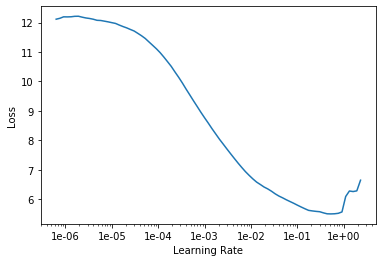

In [51]:
learn.recorder.plot()

In [ ]:
# export
multi_train(get_learn=partial(get_learn_detectsym_17clas,data=data,gaf=gaf), 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

# export

In [12]:
!python notebook2script.py --fname 'train_script_logger_std.ipynb' --outputDir './'

Converted train_script_logger_std.ipynb to nb_train_script_logger_std.py
